In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.axes_grid1 import host_subplot
from matplotlib.pyplot import figure
from pylab import rcParams

In [2]:
frac = 48 # partes en que se divide un día en el modelo

## Parámetros de fitoplancton "Algas verdes"o "Clorofíceas"

In [3]:
cloroficeas={
"alpha_max" : 1.75, #1/día
"k_r" : 0.3, #1/día
"theta" : 1.07, 
"k" : 4.962,
"a" : 31.957,
"b" : 0.018,
"I_k" : 60, # W/m^2
"k_N" : 0.0115, # mg/l
}

## Parte A

In [4]:
def runge_kutta_4(f,y0,t,chla=False):
    '''Approximate the solution of y'=f(y,t) by Runge Kutta 4 order method.

    Parameters
    ----------
    f : function
        Right-hand side of the differential equation y'=f(t,y), y(t_0)=y_0
    y0 : number
        Initial value y(t0)=y0 where t0 is the entry at index 0 in the array t
    t : array
        1D NumPy array of t values where we approximate y values. Time step
        at each iteration is given by t[n+1] - t[n].

    Returns
    -------
    y : 1D NumPy array
        Approximation y[n] of the solution y(t_n) computed by Runge Kutta 4 order method.
    '''
    y = np.zeros(len(t))
    y[0] = y0
    chla_min = 10**(-6)
    
    for n in range(0,len(t)-1):
        
        h = t[n+1] - t[n]
        k1 = f(y[n], t[n])
        k2 = f(y[n] + 1/2*h*k1, t[n] + 1/2*h)
        k3 = f(y[n] + 1/2*h*k2, t[n] + 1/2*h)
        k4 = f(y[n] + k3*h, t[n] + h)
        y_prox = y[n] + 1/6*(k1 + 2*k2 + 2*k3 + k4)*h
        
        if chla == True and y_prox < chla_min:
            y[n+1] = chla_min
        else:
            y[n+1] = y_prox
            
    return y

In [5]:
def I(t):
    return 150 + 100*np.cos(2*np.pi/365*(t + 11))

In [6]:
def Td(t):
    return 11 + 4*np.cos(2*np.pi/365*(t - 10))

In [7]:
def Tm(T,t):
    return (T + Td(t))/2

In [8]:
def beta_c(T,t):
    return 0.35 + 0.015*Tm(T,t) + 0.0012*(Tm(T,t))**2

In [9]:
def f_uw(uw):
    return 9.2 + 0.46*uw**2

In [10]:
def Ce(T,t,uw=4.8):
    return 4.5 + 0.05*T + (beta_c(T,t) + 0.47)*f_uw(uw)

In [11]:
def Te(T,t):
    return Td(t) + I(t)/Ce(T,t)

In [12]:
def Hn(T,t):
    return Ce(T,t)*(Te(T,t) - T)

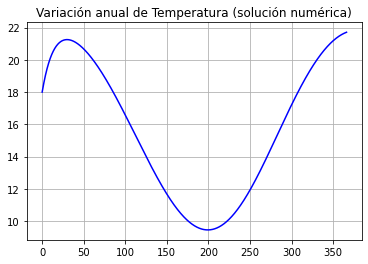

In [13]:
Cp = 4181.3 # calor específico del agua (J/°C/kg)
rho_w = 1000 # densidad del agua (kg/m^3)
D = 10 # profundidad del lago (m)
t = np.arange(1,366*frac)/frac
f1 = lambda T,t: Hn(T,t)*60*60*24/(Cp*rho_w*D)
T0 = 18 # temperatura inicial (°C)
T_anual = runge_kutta_4(f1,T0,t)
plt.plot(t,T_anual,'b-')
plt.grid(True)
plt.title("Variación anual de Temperatura (solución numérica)")
plt.show()

## Parte B

In [14]:
def f_T(T, fitopl=cloroficeas):
    theta,k,a,b = list( map(fitopl.get, ['theta','k','a','b']) )
    return theta**(T - 20) - theta**(k*(T - a)) + b

In [15]:
def f_I(t, fitopl=cloroficeas):
    I_k = fitopl['I_k']
    return 1 - np.exp(-I(t)/I_k)

In [16]:
#y=f_N(t, 0, chla_0, 0.1, fitopl=cloroficeas)
#chla=(-I(t)+250)/500+1.8
#y=N(t, 0.05, chla, 0.1)
#plt.plot(t, y,'b.-')


In [17]:
f_T(T_anual[11])

0.8860947410360943

In [18]:
def N(t, dN, chla, N_0, k_chla=0.05):
    N = N_0 + dN * np.cos(2*np.pi/365*(t+30)) - k_chla * chla
    if N<0:
        return 0
    else:
        return N

In [19]:
def f_N(t, dN, chla, N_0, fitopl=cloroficeas):
    k_N = fitopl['k_N']
    N_valor = N(t, dN, chla, N_0)
    N_list.append(N_valor)
    return N_valor/(N_valor + k_N)

In [20]:
def alpha(T, t, dN, chla, N_0, fitopl=cloroficeas):
    alpha_max = fitopl['alpha_max']
    return alpha_max * min(f_I(t) , f_N(t, dN, chla, N_0)) * f_T(T)

In [21]:
def beta(T, fitopl=cloroficeas):
    k_r = fitopl['k_r']
    return k_r * f_T(T)

In [22]:
# Lado derecho de EDO para ChlA
def f2(chla,t):
    año = 365
    if t<2*año+1:
        dN0 = 0
    elif t<6*año+1:
        dN0 = 0.05
    else:
        dN0 = 0.4
    i=int(t*frac)
    if t*frac % i == 0.0:
        return (alpha(T_anual[i-1], t, dN, chla, N_0+dN0) - beta(T_anual[i-1]))*chla
    else:
        T_interpol = (T_anual[i-1] + T_anual[i])/2
        return (alpha(T_interpol, t, dN, chla, N_0+dN0) - beta(T_interpol))*chla

In [28]:
# Cálculo de ChlA
dN = 0.04
N_0 = 0.5
t = np.arange(1,365*10*frac)/frac
#N_array = np.zeros(len(t))
T_anual = runge_kutta_4(f1,T0,t)
chla_0 = 10**(-6) # microg/l
N_list = []
chla_anual = runge_kutta_4(f2, chla_0, t, chla=True)

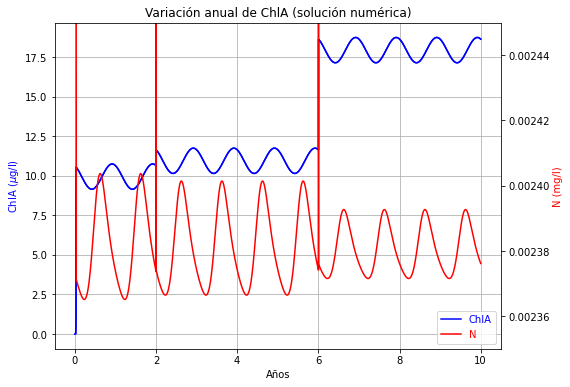

In [30]:
# Graficar ChlA versus N

N_list1 = []
for i in range(len(N_list)):
    if i%4 == 0:
        k = 1/6*(N_list[i] + 2*N_list[i+1] + 2*N_list[i+2] + N_list[i+3])
        N_list1.append(k)
N_list1.append(N_list1[-1])

host = host_subplot(111)
par = host.twinx()

host.set_xlabel('Años')
host.set_ylabel('ChlA ($\mu$g/l)')
par.set_ylabel("N (mg/l)")

p1, = host.plot(t/365, chla_anual,'b-', label="ChlA")
p2, = par.plot(t/365, N_list1,'r-', label="N")

leg = plt.legend()

host.yaxis.get_label().set_color(p1.get_color())
leg.texts[0].set_color(p1.get_color())

par.yaxis.get_label().set_color(p2.get_color())
leg.texts[1].set_color(p2.get_color())

par.set_ylim(0.00235, 0.00245)

plt.plot(t/365,chla_anual,'b-')
plt.grid(True)
plt.title("Variación anual de ChlA (solución numérica)")

rcParams["figure.figsize"] = (8,6)
plt.show()

In [25]:
# Cálculo de ChlA para dN entre 0.01 y 0.08
N_0 = 0.5
t = np.arange(1,365*10*frac+1)/frac
T_anual = runge_kutta_4(f1,T0,t)
chla_0 = 10**(-6)
t_años = t/365
lines = np.zeros((8,len(t),2))
for i in range(8):
    dN = 0.01*(i+1)
    lines[i] = np.column_stack((t_años,runge_kutta_4(f2, chla_0, t, chla=True)))

dN_array = np.arange(8)/100+0.01

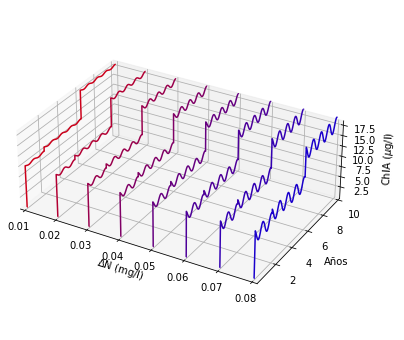

In [26]:
# Gráfico 3D de ChlA para dN entre 0.01 y 0.08
line = LineCollection(lines)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

face_color = ((0.8, 0.0, 0.1),
              (0.7, 0.0, 0.2),
              (0.6, 0.0, 0.3),
              (0.5, 0.0, 0.4),
              (0.4, 0.0, 0.5),
              (0.3, 0.0, 0.6),
              (0.2, 0.0, 0.7),
              (0.1, 0.0, 0.8)
             )
line.set_edgecolor(face_color)
ax.add_collection3d(line, zs=dN_array, zdir='x')

ax.set_ylim3d(t_años.min(), t_años.max())
ax.set_ylabel('Años')
ax.set_xlim3d(0.01, 0.08)
ax.set_xlabel('$\Delta$N (mg/l)')
ax.set_zlim3d(lines[0,:,1].min(), lines[0,:,1].max())
ax.set_zlabel('ChlA ($\mu$g/l)')
ax.set_box_aspect(aspect = (3,2,1))
rcParams["figure.figsize"] = (10,10)

fig.savefig('fig1.png',dpi=300)
plt.show()